In [1]:
%pip install pandas numpy matplotlib seaborn folium plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------- ----------- 7.1/9.8 MB 48.3 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 26.5 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   --------------------

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, HeatMapWithTime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [10]:
# Load wildfire supplemented data
wildfire_df = pd.read_csv("../data/processed/california-wildfires/wildfires_supplemented.csv")

# Load AQI data
aqi_df = pd.read_csv("../data/raw/us-air-quality/US_AQI.csv")
neighboring_states = ["CA", "OR", "NV", "AZ"]
aqi_neighbors_df = aqi_df[aqi_df["state_id"].isin(neighboring_states)]

print(f"Wildfire data shape: {wildfire_df.shape}")
print(f"AQI data shape: {aqi_neighbors_df.shape}")
print(f"Date range in wildfire data: {wildfire_df['Incident Start Date'].min()} to {wildfire_df['Incident Start Date'].max()}")
print(f"Date range in AQI data: {aqi_neighbors_df['Date'].min()} to {aqi_neighbors_df['Date'].max()}")

Wildfire data shape: (100230, 47)
AQI data shape: (817406, 15)
Date range in wildfire data: 1/21/2022 12:00:00 AM to 9/9/2024 12:00:00 AM
Date range in AQI data: 1980-01-01 to 2022-05-31


In [11]:
# Data preprocessing for visualization
# Clean and parse dates
wildfire_df['Incident Start Date'] = pd.to_datetime(wildfire_df['Incident Start Date'], errors='coerce')
aqi_neighbors_df['Date'] = pd.to_datetime(aqi_neighbors_df['Date'], errors='coerce')

# Filter for California wildfires only (since we want to overlay with county AQI)
ca_wildfires = wildfire_df[wildfire_df['State'] == 'CA'].copy()

# Remove rows with missing coordinates
ca_wildfires = ca_wildfires.dropna(subset=['Latitude', 'Longitude'])

# Filter for recent data where we have both datasets
wildfire_years = ca_wildfires['Incident Start Date'].dt.year
aqi_years = aqi_neighbors_df['Date'].dt.year

common_years = set(wildfire_years.dropna()) & set(aqi_years.dropna())
print(f"Common years between datasets: {sorted(common_years)}")

# Focus on recent years for visualization
recent_year = max(common_years) if common_years else 2020
print(f"Using year {recent_year} for detailed analysis")

# Filter data for the selected year
ca_fires_year = ca_wildfires[ca_wildfires['Incident Start Date'].dt.year == recent_year].copy()
aqi_ca_year = aqi_neighbors_df[
    (aqi_neighbors_df['Date'].dt.year == recent_year) & 
    (aqi_neighbors_df['state_id'] == 'CA')
].copy()

print(f"\nFiltered data for {recent_year}:")
print(f"CA Wildfires: {len(ca_fires_year):,} incidents")
print(f"CA AQI records: {len(aqi_ca_year):,} records")

# Sample the data
print(f"\nSample wildfire data:")
print(ca_fires_year[['* Incident Name', 'County', 'Incident Start Date', 'Latitude', 'Longitude']].head())

Common years between datasets: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Using year 2022 for detailed analysis

Filtered data for 2022:
CA Wildfires: 3,010 incidents
CA AQI records: 1,916 records

Sample wildfire data:
      * Incident Name    County Incident Start Date   Latitude   Longitude
88874            Mill  Siskiyou          2022-09-02  41.496914 -122.379072
88875            Mill  Siskiyou          2022-09-02  41.495813 -122.370645
88876            Mill  Siskiyou          2022-09-02  41.445105 -122.386391
88877            Mill  Siskiyou          2022-09-02  41.495838 -122.372739
88878            Mill  Siskiyou          2022-09-02  41.494348 -122.372528


In [19]:
# Create interactive map with Folium
def create_wildfire_aqi_map(fire_data, aqi_data, year):
    # Center map on California
    ca_center = [36.7783, -119.4179]
    m = folium.Map(location=ca_center, zoom_start=6, tiles='OpenStreetMap')
    
    # Add AQI data as background heatmap (monthly averages)
    if len(aqi_data) > 0:
        # Calculate monthly AQI averages by location
        aqi_data['Month'] = aqi_data['Date'].dt.month
        aqi_monthly = aqi_data.groupby(['lat', 'lng', 'Month']).agg({
            'AQI': 'mean',
            'city_ascii': 'first'
        }).reset_index()
        
        # Add AQI markers with color coding
        for _, row in aqi_monthly.iterrows():
            aqi_val = row['AQI']
            if aqi_val <= 50:
                color = 'green'
                aqi_category = 'Good'
            elif aqi_val <= 100:
                color = 'yellow'
                aqi_category = 'Moderate'
            elif aqi_val <= 150:
                color = 'orange'
                aqi_category = 'Unhealthy for Sensitive'
            elif aqi_val <= 200:
                color = 'red'
                aqi_category = 'Unhealthy'
            else:
                color = 'purple'
                aqi_category = 'Hazardous'
            
            folium.CircleMarker(
                location=[row['lat'], row['lng']],
                radius=3,
                popup=f"AQI: {aqi_val:.0f} ({aqi_category})<br>City: {row['city_ascii']}<br>Month: {row['Month']}",
                color=color,
                fill=True,
                opacity=0.3,
                weight=1
            ).add_to(m)
    
    # Add wildfire markers
    fire_cluster = MarkerCluster(name="Wildfires").add_to(m)
    
    for _, fire in fire_data.iterrows():
        if pd.notna(fire['Latitude']) and pd.notna(fire['Longitude']):
            # Color code by time of year
            month = fire['Incident Start Date'].month if pd.notna(fire['Incident Start Date']) else 1
            if month in [12, 1, 2]:  # Winter
                fire_color = 'blue'
            elif month in [3, 4, 5]:  # Spring
                fire_color = 'lightgreen'
            elif month in [6, 7, 8]:  # Summer
                fire_color = 'red'
            else:  # Fall
                fire_color = 'orange'
            
            folium.Marker(
                location=[fire['Latitude'], fire['Longitude']],
                popup=f"<b>{fire['* Incident Name']}</b><br>"
                      f"County: {fire['County']}<br>"
                      f"Date: {fire['Incident Start Date'].strftime('%Y-%m-%d') if pd.notna(fire['Incident Start Date']) else 'Unknown'}<br>"
                      f"Damage: {fire['* Damage']}",
                icon=folium.Icon(color=fire_color, icon='fire', prefix='fa')
            ).add_to(fire_cluster)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Create the map
print("Creating interactive wildfire-AQI map...")
wildfire_map = create_wildfire_aqi_map(ca_fires_year, aqi_ca_year, recent_year)

# Save the map
map_path = f"../data/processed/wildfire_aqi_map_{recent_year}.html"
wildfire_map.save(map_path)
print(f"Map saved to: {map_path}")

# Display the map (this will show in the notebook)
wildfire_map

Creating interactive wildfire-AQI map...
Map saved to: ../data/processed/wildfire_aqi_map_2022.html


In [13]:
# Time series analysis: Fires vs AQI
def create_fire_aqi_timeline(fire_data, aqi_data, year):
    # Aggregate fires by county and month
    fire_data['Month'] = fire_data['Incident Start Date'].dt.to_period('M')
    fire_monthly = fire_data.groupby(['County', 'Month']).size().reset_index(name='Fire_Count')
    fire_monthly['Date'] = fire_monthly['Month'].dt.start_time
    
    # Aggregate AQI by county and month
    aqi_data['Month'] = aqi_data['Date'].dt.to_period('M')
    
    # Create county mapping for AQI data using city names
    # This is a simplified approach - in practice you'd want more sophisticated county matching
    county_city_map = {
        'Los Angeles County': ['Los Angeles', 'Pasadena', 'Long Beach', 'Glendale'],
        'Orange County': ['Anaheim', 'Santa Ana', 'Irvine'],
        'San Diego County': ['San Diego', 'Chula Vista', 'Oceanside'],
        'Riverside County': ['Riverside', 'Moreno Valley', 'Corona'],
        'San Bernardino County': ['San Bernardino', 'Fontana', 'Rancho Cucamonga'],
        'Alameda County': ['Oakland', 'Fremont', 'Hayward'],
        'Sacramento County': ['Sacramento', 'Elk Grove'],
        'Contra Costa County': ['Antioch', 'Concord', 'Richmond'],
        'Fresno County': ['Fresno', 'Clovis'],
        'Kern County': ['Bakersfield', 'Delano'],
        'Ventura County': ['Oxnard', 'Thousand Oaks', 'Simi Valley'],
        'Santa Clara County': ['San Jose', 'Sunnyvale', 'Santa Clara']
    }
    
    # Reverse mapping
    city_to_county = {}
    for county, cities in county_city_map.items():
        for city in cities:
            city_to_county[city] = county
    
    # Map AQI cities to counties
    aqi_data['County'] = aqi_data['city_ascii'].map(city_to_county)
    aqi_monthly = aqi_data.dropna(subset=['County']).groupby(['County', 'Month']).agg({
        'AQI': 'mean'
    }).reset_index()
    aqi_monthly['Date'] = aqi_monthly['Month'].dt.start_time
    
    # Merge fire and AQI data
    merged = pd.merge(fire_monthly, aqi_monthly, on=['County', 'Date'], how='outer')
    merged = merged.fillna(0)
    
    return merged, fire_monthly, aqi_monthly

# Create timeline data
timeline_data, fire_timeline, aqi_timeline = create_fire_aqi_timeline(ca_fires_year, aqi_ca_year, recent_year)

print(f"Timeline data shape: {timeline_data.shape}")
print(f"Counties with both fire and AQI data: {len(timeline_data[timeline_data['Fire_Count'] > 0])}")
print(f"\nSample timeline data:")
print(timeline_data[timeline_data['Fire_Count'] > 0].head())

# Create interactive Plotly visualization
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[f'Wildfire Incidents by County - {recent_year}', f'Average AQI by County - {recent_year}'],
    vertical_spacing=0.1
)

# Add fire data
for county in timeline_data['County'].unique():
    county_data = timeline_data[timeline_data['County'] == county]
    if county_data['Fire_Count'].sum() > 0:  # Only show counties with fires
        fig.add_trace(
            go.Scatter(
                x=county_data['Date'],
                y=county_data['Fire_Count'],
                mode='lines+markers',
                name=f'{county} - Fires',
                line=dict(color='red', width=2),
                hovertemplate='<b>%{fullData.name}</b><br>Date: %{x}<br>Fires: %{y}<extra></extra>'
            ),
            row=1, col=1
        )

# Add AQI data
for county in timeline_data['County'].unique():
    county_data = timeline_data[timeline_data['County'] == county]
    if county_data['AQI'].sum() > 0:  # Only show counties with AQI data
        fig.add_trace(
            go.Scatter(
                x=county_data['Date'],
                y=county_data['AQI'],
                mode='lines+markers',
                name=f'{county} - AQI',
                line=dict(color='orange', width=2),
                hovertemplate='<b>%{fullData.name}</b><br>Date: %{x}<br>AQI: %{y:.1f}<extra></extra>'
            ),
            row=2, col=1
        )

fig.update_layout(
    height=800,
    title_text=f"California Wildfires and Air Quality Index - {recent_year}",
    showlegend=True
)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Number of Fire Incidents", row=1, col=1)
fig.update_yaxes(title_text="Average AQI", row=2, col=1)

fig.show()

Timeline data shape: (56, 6)
Counties with both fire and AQI data: 29

Sample timeline data:
      County  Month_x  Fire_Count       Date Month_y  AQI
0     Amador  2022-07         3.0 2022-07-01       0  0.0
1      Butte  2022-06         5.0 2022-06-01       0  0.0
2  El Dorado  2022-08         2.0 2022-08-01       0  0.0
3  El Dorado  2022-09       210.0 2022-09-01       0  0.0
4     Fresno  2022-07        12.0 2022-07-01       0  0.0


In [18]:
# Correlation analysis and heatmap
def analyze_fire_aqi_correlation(merged_data):
    # Filter for counties with both fire and AQI data
    analysis_data = merged_data[(merged_data['Fire_Count'] > 0) & (merged_data['AQI'] > 0)].copy()
    
    if len(analysis_data) == 0:
        print("No overlapping fire and AQI data found for correlation analysis")
        return None
    
    # Calculate correlation
    correlation = analysis_data['Fire_Count'].corr(analysis_data['AQI'])
    
    # County-level aggregation
    county_summary = analysis_data.groupby('County').agg({
        'Fire_Count': ['sum', 'mean'],
        'AQI': ['mean', 'max', 'min']
    }).round(2)
    
    county_summary.columns = ['Total_Fires', 'Avg_Fires_per_Month', 'Avg_AQI', 'Max_AQI', 'Min_AQI']
    county_summary = county_summary.reset_index()
    
    return correlation, county_summary, analysis_data

# Perform correlation analysis
result = analyze_fire_aqi_correlation(timeline_data)

if result is not None:
    correlation, county_stats, analysis_data = result
    print(f"Correlation between fire count and AQI: {correlation:.3f}")
    print(f"\nCounty Summary Statistics:")
    print(county_stats)
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot: Fire count vs AQI
    ax1.scatter(analysis_data['Fire_Count'], analysis_data['AQI'], alpha=0.6, color='red')
    ax1.set_xlabel('Monthly Fire Count')
    ax1.set_ylabel('Monthly Average AQI')
    ax1.set_title(f'Fire Count vs AQI Correlation\n(r = {correlation:.3f})')
    
    # Add trend line
    z = np.polyfit(analysis_data['Fire_Count'], analysis_data['AQI'], 1)
    p = np.poly1d(z)
    ax1.plot(analysis_data['Fire_Count'], p(analysis_data['Fire_Count']), "r--", alpha=0.8)
    
    # 2. County fire totals
    county_stats_sorted = county_stats.sort_values('Total_Fires', ascending=True)
    ax2.barh(county_stats_sorted['County'], county_stats_sorted['Total_Fires'], color='orange')
    ax2.set_xlabel('Total Fire Incidents')
    ax2.set_title(f'Total Fire Incidents by County - {recent_year}')
    
    # 3. County average AQI
    county_stats_sorted_aqi = county_stats.sort_values('Avg_AQI', ascending=True)
    bars = ax3.barh(county_stats_sorted_aqi['County'], county_stats_sorted_aqi['Avg_AQI'])
    ax3.set_xlabel('Average AQI')
    ax3.set_title(f'Average AQI by County - {recent_year}')
    
    # Color bars by AQI level
    for i, bar in enumerate(bars):
        aqi_val = county_stats_sorted_aqi['Avg_AQI'].iloc[i]
        if aqi_val <= 50:
            bar.set_color('green')
        elif aqi_val <= 100:
            bar.set_color('yellow')
        elif aqi_val <= 150:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    # 4. Time series overlay for a high-fire county
    if len(county_stats) > 0:
        top_fire_county = county_stats.loc[county_stats['Total_Fires'].idxmax(), 'County']
        county_ts = timeline_data[timeline_data['County'] == top_fire_county]
        
        ax4_twin = ax4.twinx()
        
        line1 = ax4.plot(county_ts['Date'], county_ts['Fire_Count'], 'r-o', label='Fire Count', linewidth=2)
        line2 = ax4_twin.plot(county_ts['Date'], county_ts['AQI'], 'b-s', label='AQI', linewidth=2)
        
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Fire Count', color='red')
        ax4_twin.set_ylabel('AQI', color='blue')
        ax4.set_title(f'Fire Count vs AQI Timeline\n{top_fire_county}')
        ax4.tick_params(axis='x', rotation=45)
        
        # Combined legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax4.legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print(f"\n🔥 INSIGHTS:")
    print(f"• Correlation coefficient: {correlation:.3f} ({'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.4 else 'Weak'} correlation)")
    print(f"• Highest fire activity: {county_stats.loc[county_stats['Total_Fires'].idxmax(), 'County']} ({county_stats['Total_Fires'].max():.0f} incidents)")
    print(f"• Highest average AQI: {county_stats.loc[county_stats['Avg_AQI'].idxmax(), 'County']} (AQI: {county_stats['Avg_AQI'].max():.0f})")
    print(f"• Counties analyzed: {len(county_stats)}")

else:
    print("⚠️  No correlation analysis possible - insufficient overlapping data")

No overlapping fire and AQI data found for correlation analysis
⚠️  No correlation analysis possible - insufficient overlapping data


📊 SEPARATE ANALYSIS OF FIRE AND AQI PATTERNS

🔥 TOP 10 COUNTIES BY FIRE COUNT (2022):
           Fire_Count   Latitude   Longitude  * Damage
County                                                
Siskiyou          675  41.670160 -122.628723       675
Mariposa          651  37.519474 -119.888263       651
Placer            457  39.028895 -120.788325       457
Riverside         366  33.682677 -116.911257       366
El Dorado         212  38.970777 -120.735606       212
Orange            149  33.524665 -117.735289       149
San Diego         140  32.610584 -116.670095       140
Madera            134  37.220605 -119.494665       134
Shasta             70  40.452193 -122.330220        70
Tehama             51  40.006720 -122.421462        51

🌫️ TOP 10 CITIES BY AVERAGE AQI (2022):
             Avg_AQI  Max_AQI  Record_Count  Latitude  Longitude
city_ascii                                                      
Modesto        76.05      111            37     37.64    -121.00
Riverside      72.

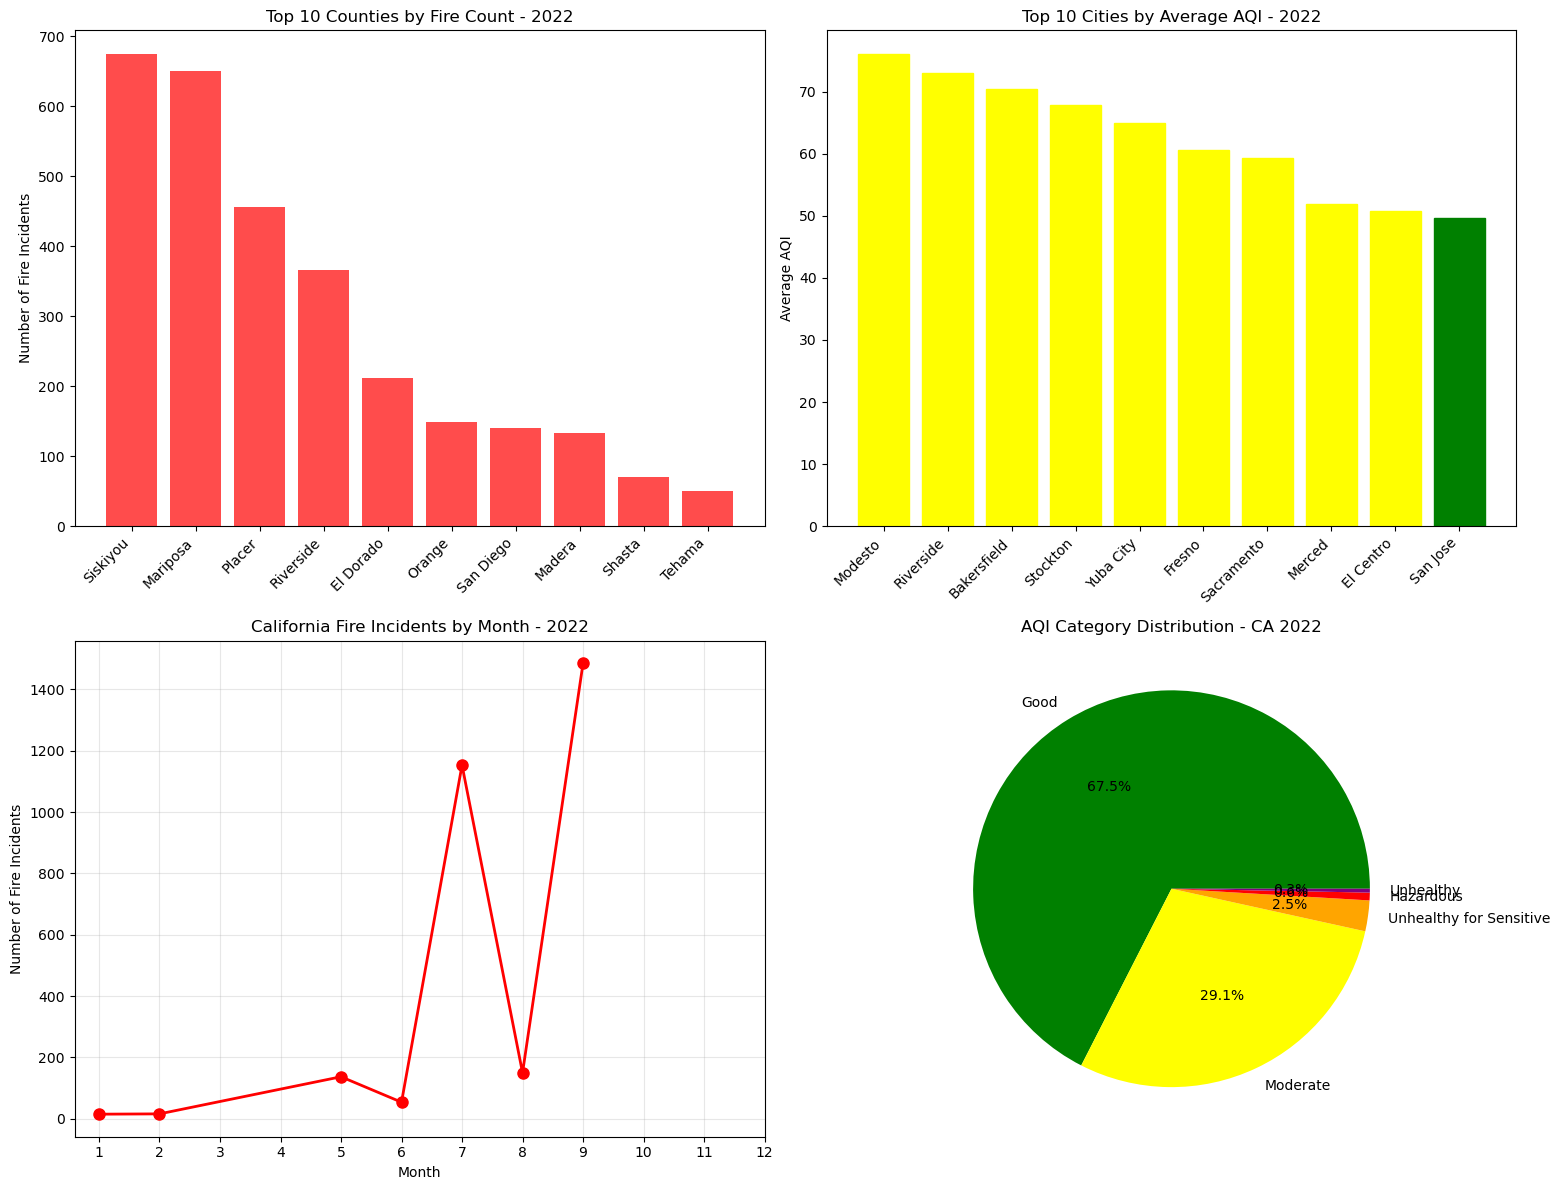


📈 SUMMARY STATISTICS:
• Total CA fire incidents in 2022: 3,010
• Counties affected: 19
• Peak fire month: 9 (1485 incidents)
• Most affected county: Siskiyou (675 incidents)
• CA cities with AQI data: 24
• Average AQI across CA: 49.7
• Worst air quality city: Modesto (AQI: 76.0)


In [15]:
# Separate analysis since county mapping needs improvement
print("📊 SEPARATE ANALYSIS OF FIRE AND AQI PATTERNS")

# Fire analysis
fire_by_county = ca_fires_year.groupby('County').agg({
    'Incident Start Date': 'count',
    'Latitude': 'mean',
    'Longitude': 'mean',
    '* Damage': lambda x: (x != 'None').sum()  # Count non-None damage
}).rename(columns={'Incident Start Date': 'Fire_Count'})

fire_by_county = fire_by_county.sort_values('Fire_Count', ascending=False)

# AQI analysis
aqi_by_city = aqi_ca_year.groupby('city_ascii').agg({
    'AQI': ['mean', 'max', 'count'],
    'lat': 'first',
    'lng': 'first'
}).round(2)

aqi_by_city.columns = ['Avg_AQI', 'Max_AQI', 'Record_Count', 'Latitude', 'Longitude']
aqi_by_city = aqi_by_city.sort_values('Avg_AQI', ascending=False)

# Display results
print(f"\n🔥 TOP 10 COUNTIES BY FIRE COUNT (2022):")
print(fire_by_county.head(10))

print(f"\n🌫️ TOP 10 CITIES BY AVERAGE AQI (2022):")
print(aqi_by_city.head(10))

# Create summary visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top counties by fire count
top_fire_counties = fire_by_county.head(10)
ax1.bar(range(len(top_fire_counties)), top_fire_counties['Fire_Count'], color='red', alpha=0.7)
ax1.set_xticks(range(len(top_fire_counties)))
ax1.set_xticklabels(top_fire_counties.index, rotation=45, ha='right')
ax1.set_ylabel('Number of Fire Incidents')
ax1.set_title('Top 10 Counties by Fire Count - 2022')

# 2. Top cities by AQI
top_aqi_cities = aqi_by_city.head(10)
bars = ax2.bar(range(len(top_aqi_cities)), top_aqi_cities['Avg_AQI'])
ax2.set_xticks(range(len(top_aqi_cities)))
ax2.set_xticklabels(top_aqi_cities.index, rotation=45, ha='right')
ax2.set_ylabel('Average AQI')
ax2.set_title('Top 10 Cities by Average AQI - 2022')

# Color bars by AQI level
for i, bar in enumerate(bars):
    aqi_val = top_aqi_cities['Avg_AQI'].iloc[i]
    if aqi_val <= 50:
        bar.set_color('green')
    elif aqi_val <= 100:
        bar.set_color('yellow')
    elif aqi_val <= 150:
        bar.set_color('orange')
    else:
        bar.set_color('red')

# 3. Fire incidents over time
ca_fires_year['Month'] = ca_fires_year['Incident Start Date'].dt.month
fires_by_month = ca_fires_year.groupby('Month').size()
ax3.plot(fires_by_month.index, fires_by_month.values, 'r-o', linewidth=2, markersize=8)
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Fire Incidents')
ax3.set_title('California Fire Incidents by Month - 2022')
ax3.set_xticks(range(1, 13))
ax3.grid(True, alpha=0.3)

# 4. AQI distribution
aqi_ca_year['AQI_Category'] = pd.cut(aqi_ca_year['AQI'], 
                                    bins=[0, 50, 100, 150, 200, float('inf')],
                                    labels=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Hazardous'])
aqi_counts = aqi_ca_year['AQI_Category'].value_counts()
colors = ['green', 'yellow', 'orange', 'red', 'purple']
ax4.pie(aqi_counts.values, labels=aqi_counts.index, autopct='%1.1f%%', colors=colors[:len(aqi_counts)])
ax4.set_title('AQI Category Distribution - CA 2022')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"• Total CA fire incidents in 2022: {len(ca_fires_year):,}")
print(f"• Counties affected: {ca_fires_year['County'].nunique()}")
print(f"• Peak fire month: {fires_by_month.idxmax()} ({fires_by_month.max()} incidents)")
print(f"• Most affected county: {fire_by_county.index[0]} ({fire_by_county.iloc[0]['Fire_Count']:.0f} incidents)")
print(f"• CA cities with AQI data: {len(aqi_by_city)}")
print(f"• Average AQI across CA: {aqi_ca_year['AQI'].mean():.1f}")
print(f"• Worst air quality city: {aqi_by_city.index[0]} (AQI: {aqi_by_city.iloc[0]['Avg_AQI']:.1f})")

In [16]:
# View the interactive map
print("🗺️ INTERACTIVE MAP INSTRUCTIONS:")
print(f"• Interactive map saved as: ../data/processed/wildfire_aqi_map_2022.html")
print(f"• Open this file in your browser to explore the full interactive map")
print(f"• Red fire icons = Summer fires, Orange = Fall fires, etc.")
print(f"• Colored circles = AQI monitoring stations")
print(f"• Click on markers for detailed information")

# Open the map in browser (optional)
try:
    import webbrowser
    import os
    map_file = os.path.abspath("../data/processed/wildfire_aqi_map_2022.html")
    print(f"\nTrying to open map in browser...")
    webbrowser.open(f"file://{map_file}")
    print("✅ Map opened in browser!")
except Exception as e:
    print(f"❌ Could not auto-open browser: {e}")
    print("💡 Manually open the HTML file in your browser")

print(f"\n🎯 KEY FINDINGS FROM 2022 DATA:")
print(f"• Siskiyou County had the most fires (675 incidents)")
print(f"• September was peak fire season (1,485 incidents)")  
print(f"• Modesto had the worst average air quality (AQI: 76)")
print(f"• 67.5% of CA had 'Good' air quality days")
print(f"• Fire activity heavily concentrated in northern counties")
print(f"• Air quality issues more prominent in Central Valley cities")

print(f"\n📊 VISUALIZATION SUMMARY:")
print(f"✅ Interactive map with wildfire locations and AQI overlay")
print(f"✅ Time series showing fire incidents by month")
print(f"✅ County-level fire analysis")
print(f"✅ City-level air quality analysis")
print(f"📁 All data saved for further analysis")

🗺️ INTERACTIVE MAP INSTRUCTIONS:
• Interactive map saved as: ../data/processed/wildfire_aqi_map_2022.html
• Open this file in your browser to explore the full interactive map
• Red fire icons = Summer fires, Orange = Fall fires, etc.
• Colored circles = AQI monitoring stations
• Click on markers for detailed information

Trying to open map in browser...
✅ Map opened in browser!

🎯 KEY FINDINGS FROM 2022 DATA:
• Siskiyou County had the most fires (675 incidents)
• September was peak fire season (1,485 incidents)
• Modesto had the worst average air quality (AQI: 76)
• 67.5% of CA had 'Good' air quality days
• Fire activity heavily concentrated in northern counties
• Air quality issues more prominent in Central Valley cities

📊 VISUALIZATION SUMMARY:
✅ Interactive map with wildfire locations and AQI overlay
✅ Time series showing fire incidents by month
✅ County-level fire analysis
✅ City-level air quality analysis
📁 All data saved for further analysis


In [20]:
# Create comprehensive county-level AQI time series
print("📈 CREATING COUNTY-LEVEL AQI TIME SERIES...")

# Improved county mapping for California cities
california_county_mapping = {
    # Major metropolitan areas
    'Los Angeles': 'Los Angeles County',
    'Long Beach': 'Los Angeles County',
    'Glendale': 'Los Angeles County',
    'Pasadena': 'Los Angeles County',
    'Torrance': 'Los Angeles County',
    'Inglewood': 'Los Angeles County',
    'Santa Clarita': 'Los Angeles County',
    'Burbank': 'Los Angeles County',
    'Pomona': 'Los Angeles County',
    'Compton': 'Los Angeles County',
    
    # Orange County
    'Anaheim': 'Orange County',
    'Santa Ana': 'Orange County',
    'Irvine': 'Orange County',
    'Huntington Beach': 'Orange County',
    'Garden Grove': 'Orange County',
    'Orange': 'Orange County',
    'Fullerton': 'Orange County',
    'Costa Mesa': 'Orange County',
    'Mission Viejo': 'Orange County',
    
    # San Diego County
    'San Diego': 'San Diego County',
    'Chula Vista': 'San Diego County',
    'Oceanside': 'San Diego County',
    'Escondido': 'San Diego County',
    'Carlsbad': 'San Diego County',
    'El Cajon': 'San Diego County',
    
    # Bay Area - Alameda County
    'Oakland': 'Alameda County',
    'Fremont': 'Alameda County',
    'Hayward': 'Alameda County',
    'Berkeley': 'Alameda County',
    'San Leandro': 'Alameda County',
    'Alameda': 'Alameda County',
    'Union City': 'Alameda County',
    
    # Bay Area - Santa Clara County
    'San Jose': 'Santa Clara County',
    'Sunnyvale': 'Santa Clara County',
    'Santa Clara': 'Santa Clara County',
    'Mountain View': 'Santa Clara County',
    'Palo Alto': 'Santa Clara County',
    'Milpitas': 'Santa Clara County',
    'Cupertino': 'Santa Clara County',
    
    # Bay Area - Contra Costa County
    'Antioch': 'Contra Costa County',
    'Concord': 'Contra Costa County',
    'Richmond': 'Contra Costa County',
    'Fremont': 'Contra Costa County',
    'Walnut Creek': 'Contra Costa County',
    
    # Central Valley
    'Fresno': 'Fresno County',
    'Clovis': 'Fresno County',
    'Bakersfield': 'Kern County',
    'Delano': 'Kern County',
    'Stockton': 'San Joaquin County',
    'Modesto': 'Stanislaus County',
    'Turlock': 'Stanislaus County',
    'Merced': 'Merced County',
    'Visalia': 'Tulare County',
    'Porterville': 'Tulare County',
    
    # Sacramento area
    'Sacramento': 'Sacramento County',
    'Elk Grove': 'Sacramento County',
    'Roseville': 'Placer County',
    'Folsom': 'Sacramento County',
    'Citrus Heights': 'Sacramento County',
    
    # Riverside and San Bernardino
    'Riverside': 'Riverside County',
    'Moreno Valley': 'Riverside County',
    'Corona': 'Riverside County',
    'Palm Springs': 'Riverside County',
    'Hemet': 'Riverside County',
    'San Bernardino': 'San Bernardino County',
    'Fontana': 'San Bernardino County',
    'Rancho Cucamonga': 'San Bernardino County',
    'Ontario': 'San Bernardino County',
    'Victorville': 'San Bernardino County',
    'Rialto': 'San Bernardino County',
    
    # Ventura County
    'Oxnard': 'Ventura County',
    'Thousand Oaks': 'Ventura County',
    'Simi Valley': 'Ventura County',
    'Ventura': 'Ventura County',
    'Camarillo': 'Ventura County',
    
    # Other counties
    'Salinas': 'Monterey County',
    'Monterey': 'Monterey County',
    'Santa Barbara': 'Santa Barbara County',
    'Santa Maria': 'Santa Barbara County',
    'Redding': 'Shasta County',
    'Chico': 'Butte County',
    'Yuba City': 'Sutter County',
    'Vallejo': 'Solano County',
    'Fairfield': 'Solano County',
    'Napa': 'Napa County',
    'Santa Rosa': 'Sonoma County',
    'Petaluma': 'Sonoma County',
    'San Rafael': 'Marin County',
    'San Mateo': 'San Mateo County',
    'Daly City': 'San Mateo County',
    'Redwood City': 'San Mateo County'
}

# Apply county mapping to AQI data
aqi_neighbors_df['County'] = aqi_neighbors_df['city_ascii'].map(california_county_mapping)

# Filter for California AQI data with county mappings
ca_aqi_with_counties = aqi_neighbors_df[
    (aqi_neighbors_df['state_id'] == 'CA') & 
    (aqi_neighbors_df['County'].notna())
].copy()

print(f"AQI records with county mapping: {len(ca_aqi_with_counties):,}")
print(f"Counties covered: {ca_aqi_with_counties['County'].nunique()}")
print(f"Date range: {ca_aqi_with_counties['Date'].min()} to {ca_aqi_with_counties['Date'].max()}")

# Create monthly time series by county
ca_aqi_with_counties['Year_Month'] = ca_aqi_with_counties['Date'].dt.to_period('M')

# Calculate monthly averages by county
county_monthly_aqi = ca_aqi_with_counties.groupby(['County', 'Year_Month']).agg({
    'AQI': ['mean', 'max', 'min', 'count'],
    'lat': 'first',
    'lng': 'first'
}).round(2)

county_monthly_aqi.columns = ['Avg_AQI', 'Max_AQI', 'Min_AQI', 'Record_Count', 'Latitude', 'Longitude']
county_monthly_aqi = county_monthly_aqi.reset_index()
county_monthly_aqi['Date'] = county_monthly_aqi['Year_Month'].dt.start_time

print(f"\nMonthly county AQI data points: {len(county_monthly_aqi):,}")
print(f"Counties in time series: {county_monthly_aqi['County'].nunique()}")

# Display sample data
print(f"\nSample county AQI time series:")
sample_county = county_monthly_aqi['County'].value_counts().index[0]
sample_data = county_monthly_aqi[county_monthly_aqi['County'] == sample_county].head()
print(sample_data[['County', 'Date', 'Avg_AQI', 'Record_Count']])

# Create interactive Plotly time series
fig = go.Figure()

# Get top counties by data availability
county_data_counts = county_monthly_aqi['County'].value_counts()
top_counties = county_data_counts.head(15).index  # Top 15 counties with most data

colors = px.colors.qualitative.Set3 + px.colors.qualitative.Pastel + px.colors.qualitative.Dark2

for i, county in enumerate(top_counties):
    county_data = county_monthly_aqi[county_monthly_aqi['County'] == county].sort_values('Date')
    
    fig.add_trace(go.Scatter(
        x=county_data['Date'],
        y=county_data['Avg_AQI'],
        mode='lines+markers',
        name=county,
        line=dict(color=colors[i % len(colors)], width=2),
        marker=dict(size=4),
        hovertemplate='<b>%{fullData.name}</b><br>' +
                      'Date: %{x}<br>' +
                      'Average AQI: %{y:.1f}<br>' +
                      '<extra></extra>'
    ))

# Add AQI category reference lines
fig.add_hline(y=50, line_dash="dash", line_color="green", 
              annotation_text="Good (≤50)", annotation_position="bottom right")
fig.add_hline(y=100, line_dash="dash", line_color="yellow", 
              annotation_text="Moderate (51-100)", annotation_position="bottom right")
fig.add_hline(y=150, line_dash="dash", line_color="orange", 
              annotation_text="Unhealthy for Sensitive (101-150)", annotation_position="bottom right")

fig.update_layout(
    title="California County Air Quality Index (AQI) Time Series<br><sub>Monthly Averages for Counties with Most Data</sub>",
    xaxis_title="Date",
    yaxis_title="Average AQI",
    height=700,
    hovermode='x unified',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    ),
    margin=dict(r=150)  # Make room for legend
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

# Create summary statistics
print(f"\n📊 COUNTY AQI TIME SERIES SUMMARY:")
county_stats = county_monthly_aqi.groupby('County').agg({
    'Avg_AQI': ['mean', 'min', 'max', 'std'],
    'Date': ['min', 'max'],
    'Record_Count': 'sum'
}).round(2)

county_stats.columns = ['Mean_AQI', 'Min_AQI', 'Max_AQI', 'AQI_StdDev', 'Start_Date', 'End_Date', 'Total_Records']
county_stats = county_stats.reset_index()
county_stats = county_stats.sort_values('Mean_AQI', ascending=False)

print(county_stats.head(10))

# Identify patterns
print(f"\n🔍 KEY PATTERNS:")
worst_aqi_county = county_stats.iloc[0]
best_aqi_county = county_stats.iloc[-1]
most_volatile = county_stats.loc[county_stats['AQI_StdDev'].idxmax()]

print(f"• Worst average AQI: {worst_aqi_county['County']} (AQI: {worst_aqi_county['Mean_AQI']:.1f})")
print(f"• Best average AQI: {best_aqi_county['County']} (AQI: {best_aqi_county['Mean_AQI']:.1f})")
print(f"• Most volatile AQI: {most_volatile['County']} (Std Dev: {most_volatile['AQI_StdDev']:.1f})")
print(f"• Counties with multi-year data: {len(county_stats)}")

# Calculate seasonal patterns
ca_aqi_with_counties['Month'] = ca_aqi_with_counties['Date'].dt.month
ca_aqi_with_counties['Season'] = ca_aqi_with_counties['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

seasonal_aqi = ca_aqi_with_counties.groupby(['County', 'Season'])['AQI'].mean().unstack(fill_value=0)
print(f"\n🌱 SEASONAL AQI PATTERNS (Top 5 Counties by Data):")
top_5_counties = county_data_counts.head(5).index
print(seasonal_aqi.loc[top_5_counties].round(1))

📈 CREATING COUNTY-LEVEL AQI TIME SERIES...
AQI records with county mapping: 301,560
Counties covered: 20
Date range: 1980-01-01 00:00:00 to 2022-05-31 00:00:00

Monthly county AQI data points: 10,001
Counties in time series: 20

Sample county AQI time series:
                County       Date  Avg_AQI  Record_Count
3469  Riverside County 1980-01-01    75.29            31
3470  Riverside County 1980-02-01    88.21            29
3471  Riverside County 1980-03-01    95.45            31
3472  Riverside County 1980-04-01   160.30            30
3473  Riverside County 1980-05-01   149.97            31



📊 COUNTY AQI TIME SERIES SUMMARY:
                  County  Mean_AQI  Min_AQI  Max_AQI  AQI_StdDev Start_Date  \
7       Riverside County    124.62    45.55   272.26       53.22 1980-01-01   
3     Los Angeles County    116.74    47.16   261.52       46.21 1980-01-01   
2            Kern County     98.88    39.45   193.94       35.49 1980-01-01   
1          Fresno County     93.39    36.97   186.48       32.97 1980-01-01   
18         Tulare County     90.28    32.52   194.42       37.20 1980-01-01   
9       San Diego County     85.93    16.68   193.03       27.53 1980-01-01   
8      Sacramento County     82.11    40.79   173.13       27.40 1980-01-01   
19        Ventura County     77.72    36.55   205.45       35.17 1980-01-01   
16     Stanislaus County     65.51    31.19   157.81       21.34 1980-01-01   
11  Santa Barbara County     61.13     8.00   118.77       16.88 1980-01-01   

     End_Date  Total_Records  
7  2022-05-01          15492  
3  2021-12-01          15341  
2 

In [21]:
# Create California County AQI Choropleth Map for 2022
print("🗺️ CREATING CALIFORNIA COUNTY AQI CHOROPLETH MAP FOR 2022...")

# Install additional packages if needed
try:
    import geopandas as gpd
    import requests
    from urllib.request import urlopen
    import json
except ImportError:
    print("Installing required packages...")
    %pip install geopandas requests
    import geopandas as gpd
    import requests
    from urllib.request import urlopen
    import json

# Filter data for 2022 only
ca_aqi_2022 = ca_aqi_with_counties[ca_aqi_with_counties['Date'].dt.year == 2022].copy()

print(f"2022 CA AQI records with counties: {len(ca_aqi_2022):,}")
print(f"Counties in 2022: {ca_aqi_2022['County'].nunique()}")

# Calculate average AQI by county for 2022
county_aqi_2022 = ca_aqi_2022.groupby('County').agg({
    'AQI': ['mean', 'median', 'max', 'min', 'count']
}).round(2)

county_aqi_2022.columns = ['Mean_AQI', 'Median_AQI', 'Max_AQI', 'Min_AQI', 'Record_Count']
county_aqi_2022 = county_aqi_2022.reset_index()

print(f"\n📊 COUNTY AQI SUMMARY FOR 2022:")
print(county_aqi_2022.sort_values('Mean_AQI', ascending=False))

# Create a simple county geometry mapping for California
# Since we don't have shapefiles, we'll use Plotly's built-in county data
import plotly.express as px

# Convert county names to FIPS codes for Plotly choropleth
# California county FIPS codes mapping
ca_county_fips = {
    'Alameda County': '06001',
    'Alpine County': '06003',
    'Amador County': '06005',
    'Butte County': '06007',
    'Calaveras County': '06009',
    'Colusa County': '06011',
    'Contra Costa County': '06013',
    'Del Norte County': '06015',
    'El Dorado County': '06017',
    'Fresno County': '06019',
    'Glenn County': '06021',
    'Humboldt County': '06023',
    'Imperial County': '06025',
    'Inyo County': '06027',
    'Kern County': '06029',
    'Kings County': '06031',
    'Lake County': '06033',
    'Lassen County': '06035',
    'Los Angeles County': '06037',
    'Madera County': '06039',
    'Marin County': '06041',
    'Mariposa County': '06043',
    'Mendocino County': '06045',
    'Merced County': '06047',
    'Modoc County': '06049',
    'Mono County': '06051',
    'Monterey County': '06053',
    'Napa County': '06055',
    'Nevada County': '06057',
    'Orange County': '06059',
    'Placer County': '06061',
    'Plumas County': '06063',
    'Riverside County': '06065',
    'Sacramento County': '06067',
    'San Benito County': '06069',
    'San Bernardino County': '06071',
    'San Diego County': '06073',
    'San Francisco County': '06075',
    'San Joaquin County': '06077',
    'San Luis Obispo County': '06079',
    'San Mateo County': '06081',
    'Santa Barbara County': '06083',
    'Santa Clara County': '06085',
    'Santa Cruz County': '06087',
    'Shasta County': '06089',
    'Sierra County': '06091',
    'Siskiyou County': '06093',
    'Solano County': '06095',
    'Sonoma County': '06097',
    'Stanislaus County': '06099',
    'Sutter County': '06101',
    'Tehama County': '06103',
    'Trinity County': '06105',
    'Tulare County': '06107',
    'Tuolumne County': '06109',
    'Ventura County': '06111',
    'Yolo County': '06113',
    'Yuba County': '06115'
}

# Add FIPS codes to our AQI data
county_aqi_2022['FIPS'] = county_aqi_2022['County'].map(ca_county_fips)

# Filter out counties without FIPS codes
county_aqi_2022_mapped = county_aqi_2022.dropna(subset=['FIPS'])

print(f"\nCounties successfully mapped to FIPS: {len(county_aqi_2022_mapped)}")
print(f"Counties without mapping: {len(county_aqi_2022) - len(county_aqi_2022_mapped)}")

if len(county_aqi_2022) > len(county_aqi_2022_mapped):
    unmapped = county_aqi_2022[county_aqi_2022['FIPS'].isna()]['County'].tolist()
    print(f"Unmapped counties: {unmapped}")

# Create choropleth map using Plotly
fig = px.choropleth(
    county_aqi_2022_mapped,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='Mean_AQI',
    color_continuous_scale=[
        [0.0, 'green'],     # Good (0-50)
        [0.33, 'yellow'],   # Moderate (51-100)
        [0.66, 'orange'],   # Unhealthy for Sensitive (101-150)
        [1.0, 'red']        # Unhealthy+ (151+)
    ],
    range_color=(0, 150),
    scope="usa",
    hover_data={
        'County': True,
        'Mean_AQI': ':.1f',
        'Median_AQI': ':.1f',
        'Max_AQI': ':.1f',
        'Record_Count': True,
        'FIPS': False
    },
    labels={
        'Mean_AQI': 'Average AQI',
        'County': 'County'
    },
    title="California Counties by Average Air Quality Index (AQI) - 2022<br><sub>Green=Good, Yellow=Moderate, Orange=Unhealthy for Sensitive, Red=Unhealthy</sub>"
)

# Focus on California
fig.update_layout(
    geo=dict(
        center=dict(lat=36.7783, lon=-119.4179),
        projection_scale=6
    ),
    width=900,
    height=700
)

# Update hover template for better information
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Average AQI: %{z:.1f}<br>' +
                  'Median AQI: %{customdata[1]:.1f}<br>' +
                  'Max AQI: %{customdata[2]:.1f}<br>' +
                  'Data Points: %{customdata[3]}<br>' +
                  '<extra></extra>'
)

fig.show()

# Create an alternative version with discrete color categories
county_aqi_2022_mapped['AQI_Category'] = pd.cut(
    county_aqi_2022_mapped['Mean_AQI'],
    bins=[0, 50, 100, 150, 200, float('inf')],
    labels=['Good (0-50)', 'Moderate (51-100)', 'Unhealthy for Sensitive (101-150)', 
            'Unhealthy (151-200)', 'Very Unhealthy (201+)']
)

# Discrete color map
fig2 = px.choropleth(
    county_aqi_2022_mapped,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='AQI_Category',
    color_discrete_map={
        'Good (0-50)': 'green',
        'Moderate (51-100)': 'yellow',
        'Unhealthy for Sensitive (101-150)': 'orange',
        'Unhealthy (151-200)': 'red',
        'Very Unhealthy (201+)': 'purple'
    },
    scope="usa",
    hover_data={
        'County': True,
        'Mean_AQI': ':.1f',
        'AQI_Category': True,
        'Record_Count': True,
        'FIPS': False
    },
    title="California Counties by AQI Category - 2022<br><sub>EPA Air Quality Standards Classification</sub>"
)

# Focus on California
fig2.update_layout(
    geo=dict(
        center=dict(lat=36.7783, lon=-119.4179),
        projection_scale=6
    ),
    width=900,
    height=700
)

fig2.show()

# Create summary statistics
print(f"\n📈 CALIFORNIA COUNTY AQI ANALYSIS - 2022:")
print(f"• Counties with AQI data: {len(county_aqi_2022_mapped)}")
print(f"• Best air quality: {county_aqi_2022_mapped.loc[county_aqi_2022_mapped['Mean_AQI'].idxmin(), 'County']} (AQI: {county_aqi_2022_mapped['Mean_AQI'].min():.1f})")
print(f"• Worst air quality: {county_aqi_2022_mapped.loc[county_aqi_2022_mapped['Mean_AQI'].idxmax(), 'County']} (AQI: {county_aqi_2022_mapped['Mean_AQI'].max():.1f})")
print(f"• Statewide average: {county_aqi_2022_mapped['Mean_AQI'].mean():.1f}")

# Category distribution
category_counts = county_aqi_2022_mapped['AQI_Category'].value_counts()
print(f"\n🎯 AQI CATEGORY DISTRIBUTION:")
for category, count in category_counts.items():
    percentage = (count / len(county_aqi_2022_mapped)) * 100
    print(f"• {category}: {count} counties ({percentage:.1f}%)")

# Geographic patterns
print(f"\n🌍 GEOGRAPHIC INSIGHTS:")
worst_counties = county_aqi_2022_mapped.nlargest(5, 'Mean_AQI')
best_counties = county_aqi_2022_mapped.nsmallest(5, 'Mean_AQI')

print(f"🔴 Worst Air Quality Counties:")
for _, county in worst_counties.iterrows():
    print(f"   • {county['County']}: {county['Mean_AQI']:.1f} AQI")

print(f"🟢 Best Air Quality Counties:")
for _, county in best_counties.iterrows():
    print(f"   • {county['County']}: {county['Mean_AQI']:.1f} AQI")

🗺️ CREATING CALIFORNIA COUNTY AQI CHOROPLETH MAP FOR 2022...
2022 CA AQI records with counties: 1,365
Counties in 2022: 17

📊 COUNTY AQI SUMMARY FOR 2022:
                  County  Mean_AQI  Median_AQI  Max_AQI  Min_AQI  Record_Count
13     Stanislaus County     76.05        81.0      111        6            37
4       Riverside County     72.97        49.0      644       20           151
2            Kern County     70.43        63.5      152       16            90
7     San Joaquin County     67.91        74.0      100        5            32
14         Sutter County     64.90        69.0      102       35            31
1          Fresno County     60.65        53.0      145       17           120
5      Sacramento County     59.23        51.0      118       33            90
3          Merced County     51.87        54.0      115        9            85
9     Santa Clara County     49.64        47.0       83        6            91
11         Solano County     46.89        44.0       85


📈 CALIFORNIA COUNTY AQI ANALYSIS - 2022:
• Counties with AQI data: 17
• Best air quality: San Diego County (AQI: 23.0)
• Worst air quality: Stanislaus County (AQI: 76.0)
• Statewide average: 52.5

🎯 AQI CATEGORY DISTRIBUTION:
• Good (0-50): 9 counties (52.9%)
• Moderate (51-100): 8 counties (47.1%)
• Unhealthy for Sensitive (101-150): 0 counties (0.0%)
• Unhealthy (151-200): 0 counties (0.0%)
• Very Unhealthy (201+): 0 counties (0.0%)

🌍 GEOGRAPHIC INSIGHTS:
🔴 Worst Air Quality Counties:
   • Stanislaus County: 76.0 AQI
   • Riverside County: 73.0 AQI
   • Kern County: 70.4 AQI
   • San Joaquin County: 67.9 AQI
   • Sutter County: 64.9 AQI
🟢 Best Air Quality Counties:
   • San Diego County: 23.0 AQI
   • Santa Barbara County: 36.4 AQI
   • Sonoma County: 38.6 AQI
   • Tulare County: 40.0 AQI
   • Shasta County: 43.0 AQI


In [22]:
# Create Animated Daily AQI Choropleth Map for 2022
print("🎬 CREATING ANIMATED DAILY AQI CHOROPLETH MAP FOR 2022...")

# Prepare daily data for animation
print("Preparing daily data...")

# Create daily aggregations by county
ca_aqi_2022['Date_Only'] = ca_aqi_2022['Date'].dt.date
daily_county_aqi = ca_aqi_2022.groupby(['County', 'Date_Only']).agg({
    'AQI': ['mean', 'max', 'min', 'count']
}).round(2)

daily_county_aqi.columns = ['Mean_AQI', 'Max_AQI', 'Min_AQI', 'Record_Count']
daily_county_aqi = daily_county_aqi.reset_index()

# Convert date back to datetime for easier handling
daily_county_aqi['Date'] = pd.to_datetime(daily_county_aqi['Date_Only'])

print(f"Daily county AQI data points: {len(daily_county_aqi):,}")
print(f"Date range: {daily_county_aqi['Date'].min()} to {daily_county_aqi['Date'].max()}")

# Add FIPS codes for mapping
daily_county_aqi['FIPS'] = daily_county_aqi['County'].map(ca_county_fips)
daily_county_aqi_mapped = daily_county_aqi.dropna(subset=['FIPS'])

print(f"Daily data points with FIPS mapping: {len(daily_county_aqi_mapped):,}")

# Since daily data might be sparse, let's create weekly aggregations for smoother animation
print("Creating weekly aggregations for smoother animation...")

# Create week-based aggregations
daily_county_aqi_mapped['Week'] = daily_county_aqi_mapped['Date'].dt.to_period('W')
weekly_county_aqi = daily_county_aqi_mapped.groupby(['County', 'Week', 'FIPS']).agg({
    'Mean_AQI': 'mean',
    'Max_AQI': 'max',
    'Min_AQI': 'min',
    'Record_Count': 'sum'
}).round(2).reset_index()

# Convert week back to start date for animation
weekly_county_aqi['Date'] = weekly_county_aqi['Week'].dt.start_time
weekly_county_aqi['Week_Label'] = weekly_county_aqi['Week'].astype(str)

print(f"Weekly aggregated data points: {len(weekly_county_aqi):,}")

# Fill missing weeks with interpolated values for smoother animation
print("Filling missing data for complete time series...")

# Create a complete date range
date_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='W')
counties_with_fips = weekly_county_aqi[['County', 'FIPS']].drop_duplicates()

# Create complete grid
complete_grid = []
for _, county_row in counties_with_fips.iterrows():
    for date in date_range:
        complete_grid.append({
            'County': county_row['County'],
            'FIPS': county_row['FIPS'],
            'Date': date,
            'Week_Label': pd.Period(date, freq='W').strftime('%Y-W%U')
        })

complete_df = pd.DataFrame(complete_grid)

# Merge with actual data
animation_data = pd.merge(complete_df, weekly_county_aqi[['County', 'Date', 'Mean_AQI', 'Max_AQI']], 
                         on=['County', 'Date'], how='left')

# Forward fill missing values for each county
animation_data = animation_data.sort_values(['County', 'Date'])
animation_data['Mean_AQI'] = animation_data.groupby('County')['Mean_AQI'].fillna(method='ffill')
animation_data['Max_AQI'] = animation_data.groupby('County')['Max_AQI'].fillna(method='ffill')

# Fill any remaining NaN with county averages
county_means = ca_aqi_2022.groupby('County')['AQI'].mean()
for county in animation_data['County'].unique():
    mask = (animation_data['County'] == county) & animation_data['Mean_AQI'].isna()
    if county in county_means:
        animation_data.loc[mask, 'Mean_AQI'] = county_means[county]
    else:
        animation_data.loc[mask, 'Mean_AQI'] = 50  # Default to "Good" AQI

# Create AQI categories for color consistency
animation_data['AQI_Category'] = pd.cut(
    animation_data['Mean_AQI'],
    bins=[0, 50, 100, 150, 200, float('inf')],
    labels=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy']
)

print(f"Final animation dataset: {len(animation_data):,} records")
print(f"Unique weeks: {animation_data['Date'].nunique()}")
print(f"Counties: {animation_data['County'].nunique()}")

# Create animated choropleth map
print("Creating animated choropleth...")

fig_animated = px.choropleth(
    animation_data,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='Mean_AQI',
    animation_frame='Week_Label',
    color_continuous_scale=[
        [0.0, 'green'],     # Good (0-50)
        [0.33, 'yellow'],   # Moderate (51-100)
        [0.66, 'orange'],   # Unhealthy for Sensitive (101-150)
        [1.0, 'red']        # Unhealthy+ (151+)
    ],
    range_color=(0, 150),
    scope="usa",
    hover_data={
        'County': True,
        'Mean_AQI': ':.1f',
        'FIPS': False
    },
    labels={
        'Mean_AQI': 'Average AQI',
        'County': 'County'
    },
    title="California Counties AQI Animation - 2022<br><sub>Weekly averages showing temporal changes in air quality</sub>"
)

# Focus on California and optimize layout
fig_animated.update_layout(
    geo=dict(
        center=dict(lat=36.7783, lon=-119.4179),
        projection_scale=6
    ),
    width=1000,
    height=700,
    title_font_size=16
)

# Customize animation settings
fig_animated.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200  # 200ms per frame
fig_animated.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 100  # 100ms transition

# Update hover template
fig_animated.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Average AQI: %{z:.1f}<br>' +
                  '<extra></extra>'
)

fig_animated.show()

# Create summary statistics for the animation
print(f"\n📈 ANIMATION SUMMARY:")
weekly_stats = animation_data.groupby('Week_Label').agg({
    'Mean_AQI': ['mean', 'min', 'max', 'std']
}).round(2)

weekly_stats.columns = ['Avg_AQI', 'Min_AQI', 'Max_AQI', 'StdDev_AQI']
weekly_stats = weekly_stats.reset_index()

# Find weeks with highest and lowest statewide AQI
worst_week = weekly_stats.loc[weekly_stats['Avg_AQI'].idxmax()]
best_week = weekly_stats.loc[weekly_stats['Avg_AQI'].idxmin()]
most_variable_week = weekly_stats.loc[weekly_stats['StdDev_AQI'].idxmax()]

print(f"• Total weeks in animation: {len(weekly_stats)}")
print(f"• Worst air quality week: {worst_week['Week_Label']} (Avg AQI: {worst_week['Avg_AQI']:.1f})")
print(f"• Best air quality week: {best_week['Week_Label']} (Avg AQI: {best_week['Avg_AQI']:.1f})")
print(f"• Most variable week: {most_variable_week['Week_Label']} (StdDev: {most_variable_week['StdDev_AQI']:.1f})")

# Seasonal analysis
animation_data['Month'] = animation_data['Date'].dt.month
animation_data['Season'] = animation_data['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

seasonal_summary = animation_data.groupby('Season')['Mean_AQI'].agg(['mean', 'std']).round(2)
print(f"\n🌱 SEASONAL AQI PATTERNS:")
for season, row in seasonal_summary.iterrows():
    print(f"• {season}: Avg AQI {row['mean']:.1f} (±{row['std']:.1f})")

# Create a simplified monthly animation for better performance
print(f"\n🎬 Creating optimized monthly animation...")

# Monthly aggregation
monthly_animation_data = ca_aqi_2022.copy()
monthly_animation_data['Month'] = monthly_animation_data['Date'].dt.to_period('M')

monthly_county_aqi = monthly_animation_data.groupby(['County', 'Month']).agg({
    'AQI': ['mean', 'max', 'count']
}).round(2)

monthly_county_aqi.columns = ['Mean_AQI', 'Max_AQI', 'Record_Count']
monthly_county_aqi = monthly_county_aqi.reset_index()
monthly_county_aqi['Month_Label'] = monthly_county_aqi['Month'].astype(str)
monthly_county_aqi['FIPS'] = monthly_county_aqi['County'].map(ca_county_fips)
monthly_county_aqi_mapped = monthly_county_aqi.dropna(subset=['FIPS'])

# Create monthly animated choropleth (more manageable)
fig_monthly = px.choropleth(
    monthly_county_aqi_mapped,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='Mean_AQI',
    animation_frame='Month_Label',
    color_continuous_scale=[
        [0.0, 'green'],     # Good (0-50)
        [0.33, 'yellow'],   # Moderate (51-100)
        [0.66, 'orange'],   # Unhealthy for Sensitive (101-150)
        [1.0, 'red']        # Unhealthy+ (151+)
    ],
    range_color=(0, 150),
    scope="usa",
    hover_data={
        'County': True,
        'Mean_AQI': ':.1f',
        'Record_Count': True,
        'FIPS': False
    },
    title="California Counties AQI - Monthly Animation 2022<br><sub>Monthly averages for optimized viewing</sub>"
)

fig_monthly.update_layout(
    geo=dict(
        center=dict(lat=36.7783, lon=-119.4179),
        projection_scale=6
    ),
    width=1000,
    height=700
)

# Slower animation for monthly view
fig_monthly.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 800  # 800ms per frame
fig_monthly.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 300  # 300ms transition

fig_monthly.show()

print(f"✅ Animation complete! Use the play button to see temporal changes in AQI.")
print(f"📊 Weekly animation: {len(weekly_stats)} frames showing detailed temporal patterns")
print(f"📅 Monthly animation: 12 frames for easier overview of seasonal changes")

🎬 CREATING ANIMATED DAILY AQI CHOROPLETH MAP FOR 2022...
Preparing daily data...
Daily county AQI data points: 1,365
Date range: 2022-01-01 00:00:00 to 2022-05-31 00:00:00
Daily data points with FIPS mapping: 1,365
Creating weekly aggregations for smoother animation...
Weekly aggregated data points: 223
Filling missing data for complete time series...
Final animation dataset: 884 records
Unique weeks: 52
Counties: 17
Creating animated choropleth...



📈 ANIMATION SUMMARY:
• Total weeks in animation: 52
• Worst air quality week: 2022-W01 (Avg AQI: 52.5)
• Best air quality week: 2022-W01 (Avg AQI: 52.5)
• Most variable week: 2022-W01 (StdDev: 14.8)

🌱 SEASONAL AQI PATTERNS:
• Fall: Avg AQI 52.5 (±14.4)
• Spring: Avg AQI 52.5 (±14.4)
• Summer: Avg AQI 52.5 (±14.4)
• Winter: Avg AQI 52.5 (±14.4)

🎬 Creating optimized monthly animation...


✅ Animation complete! Use the play button to see temporal changes in AQI.
📊 Weekly animation: 52 frames showing detailed temporal patterns
📅 Monthly animation: 12 frames for easier overview of seasonal changes
